# 💡 SUPPLY / DEMAND INDICATOR

## 📌 Overview
This notebook link the two previously processed - supply (JOCAS) and demand (STMT) for the year 2020 - dataset in order to build a simple indicator of tension at the commune level (most granular possible). 

In [5]:
# Import Libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import unidecode # To standardize strings
import re # For regular expression
import geopandas as gpd # To read geospatial data

In [204]:
# Get the project's root directory
base_folder = Path().resolve()  # Gets the current working directory
main_folder = base_folder.parent

# Importing files to be used in the script
stmt_path = main_folder / "data" / "2- Formatted Data" / "stmt_demand_processed.csv"
stmt = pd.read_csv(stmt_path)
jocas_path = main_folder / "data" / "2- Formatted Data" / "jocas_offers_processed.csv"
jocas = pd.read_csv(jocas_path)
shapefile_path = main_folder / "data" / "shapefiles" / "Zones d'Emploi" / "ze2020_2022.shp"
ze_shp = gpd.read_file(shapefile_path)
comm_to_ze_path = main_folder / "data" / "linking tables" / "Communes_to_ZE_2022.xlsx"
comm_to_ze = pd.read_excel(comm_to_ze_path, sheet_name=1, skiprows=5)

# Specify the paths
output_path = main_folder / "data" / "2- Formatted Data" / "ratio_supply_demand.csv"  

## 1- WORKFLOW

In [177]:
#----------------------- MERGING BOTH DATASET ---------------------------#

df = jocas.merge(stmt, on=["commune", "fap87", "month"], how="outer")


#--------------------- COMMUNES TO ZONE-D'EMPLOI ------------------------#

# rename column
comm_to_ze.rename(columns={"LIBGEO": "commune", "LIBZE2020": "zone_emploi"}, inplace=True)

# Standardization function (for strings)
def standardize_commune(name):
    if pd.isna(name):
        return None
    name = unidecode.unidecode(name.lower().strip())  # Remove accents & lowercase
    name = re.sub(r"[-'’]", " ", name)  # Remove hyphens & apostrophes
    name = re.sub(r"\bst[ .]", "saint ", name)  # Standardize "St." -> "Saint"
    return name

# Apply standardization on commune column of shapefile
comm_to_ze["commune"] = comm_to_ze["commune"].apply(standardize_commune)

# Merge dataset with shapefile by commune to get zone d'emploi
df = df.merge(comm_to_ze, on="commune", how="left")

# Aggregate by zone d'emploi instead of communes
df = df.groupby(["zone_emploi", "fap87", "month"], as_index=False).agg(
    job_offers_fap87=("job_offers_fap87", "sum"),
    jobseekers_fap87=("jobseekers_fap87", "sum")
)

#--------------------------- PRE-PROCESSING -----------------------------#

# Reconcert to numeric
df["job_offers_fap87"] = pd.to_numeric(df["job_offers_fap87"], errors='coerce').astype(int)
df["jobseekers_fap87"] = pd.to_numeric(df["jobseekers_fap87"], errors='coerce').astype(int)

# When there is no offer and some demand, the ratio of the two will be 0 (low tension) -> OK
df["job_offers_fap87"] = np.where(df["job_offers_fap87"] == 0, 0, df["job_offers_fap87"])

# When there is no demand and some offer, we replace 0 demand by 1 demand to avoid 0 division
df["jobseekers_fap87"] = np.where(df["jobseekers_fap87"] == 0, 1, df["jobseekers_fap87"])


#------------------------- COMPUTING RATIO ------------------------------#

# Compute ratio
df["ratio"] = df["job_offers_fap87"] / df["jobseekers_fap87"]

# Compute mean and standard deviation
mean_tightness = df["ratio"].mean()
std_tightness = df["ratio"].std()

# Compute standardized score (Z-score)
df["ratio_zscore"] = (df["ratio"] - mean_tightness) / std_tightness


#------------------------- COMPUTING SCORE ------------------------------#

# Define quintile bins based on the z-score distribution
df["labour_tigthness_score"] = pd.qcut(df["ratio_zscore"], q=5, labels=[1, 2, 3, 4, 5])

# Convert to integer
df["labour_tigthness_score"] = df["labour_tigthness_score"].astype(int)


#---------------------- RE-MERGE WITH SHAPEFILE ------------------------#

# Merge dataset with zone d'emploi shapefile 
df = df.merge(ze_shp, left_on="zone_emploi", right_on="libze2020", how="left")
df


,zone_emploi,fap87,month,job_offers_fap87,jobseekers_fap87,ratio,ratio_zscore,labour_tigthness_score,ze2020,libze2020,nb_com,geometry
0,Abbeville,A0Z,April,3,10,0.3000,-0.282318,3,3201,Abbeville,166,"POLYGON ((1.7311 49.871, 1.7187 49.866, 1.7118..."
1,Abbeville,A0Z,August,2,10,0.2000,-0.294437,2,3201,Abbeville,166,"POLYGON ((1.7311 49.871, 1.7187 49.866, 1.7118..."
2,Abbeville,A0Z,December,0,10,0.0000,-0.318674,1,3201,Abbeville,166,"POLYGON ((1.7311 49.871, 1.7187 49.866, 1.7118..."
3,Abbeville,A0Z,February,0,20,0.0000,-0.318674,1,3201,Abbeville,166,"POLYGON ((1.7311 49.871, 1.7187 49.866, 1.7118..."
4,Abbeville,A0Z,January,2,10,0.2000,-0.294437,2,3201,Abbeville,166,"POLYGON ((1.7311 49.871, 1.7187 49.866, 1.7118..."
...,...,...,...,...,...,...,...,...,...,...,...,...
270346,Épinal,W1Z,March,3,80,0.0375,-0.314129,1,4407,Épinal,328,"POLYGON ((5.9326 47.938, 5.9376 47.951, 5.9597..."
270347,Épinal,W1Z,May,4,80,0.0500,-0.312615,1,4407,Épinal,328,"POLYGON ((5.9326 47.938, 5.9376 47.951, 5.9597..."
270348,Épinal,W1Z,November,3,80,0.0375,-0.314129,1,4407,Épinal,328,"POLYGON ((5.9326 47.938, 5.9376 47.951, 5.9597..."
270349,Épinal,W1Z,October,17,80,0.2125,-0.292922,2,4407,Épinal,328,"POLYGON ((5.9326 47.938, 5.9376 47.951, 5.9597..."


## 2- CHECKS

Only 4 zones urbaines are not covered by our data, however it is important to note that data for each zone urbaine is only linked to communes with more than 5000 habitants.

In [199]:
ze_tot = ze_shp["libze2020"].nunique()
print(f"Number of zone d'emplois in France: {ze_tot}")

ze_df = df["libze2020"].nunique()
print(f"Number of zone d'emplois in France: {ze_df}")

Number of zone d'emplois in France: 305
Number of zone d'emplois in France: 301


In theory when job=supply the ratio should be 1, let's check at each score category

In [189]:
for score in [1,2,3,4,5]:
    max_ratio = df[df["labour_tigthness_score"]==score]["ratio"].max()
    max_ratio = round(max_ratio, 2)
    print(f"The maximum ratio for score category {score} is: {max_ratio}")

The maximum ratio for score category 1 is: 0.08
The maximum ratio for score category 2 is: 0.23
The maximum ratio for score category 3 is: 0.7
The maximum ratio for score category 4 is: 2.03
The maximum ratio for score category 5 is: 447.0


Looking at the distribution of row ratios, we can see that most of values are close to 0

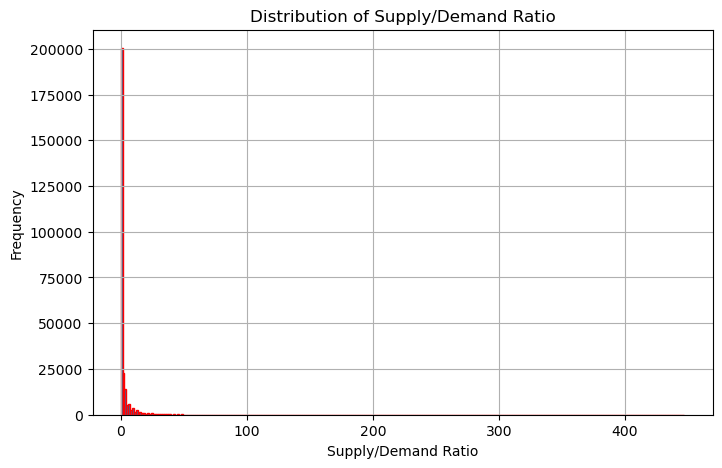

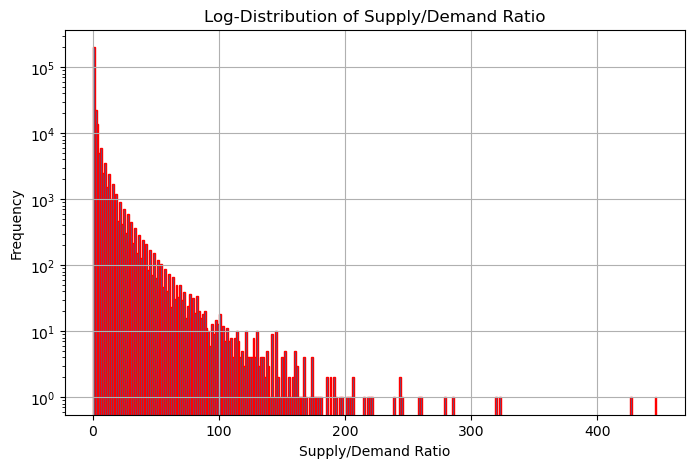

In [193]:
# Distribution of "ratio"
plt.figure(figsize=(8, 5))
df["ratio"].hist(bins=300, edgecolor="red")
plt.xlabel("Supply/Demand Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Supply/Demand Ratio")
plt.show()

# Log-Distribution of "ratio"
plt.figure(figsize=(8, 5))
df["ratio"].hist(bins=300, edgecolor="red")
plt.yscale("log")
plt.xlabel("Supply/Demand Ratio")
plt.ylabel("Frequency")
plt.title("Log-Distribution of Supply/Demand Ratio")
plt.show()

The within-year standaridization reduces the range of ratio distribution

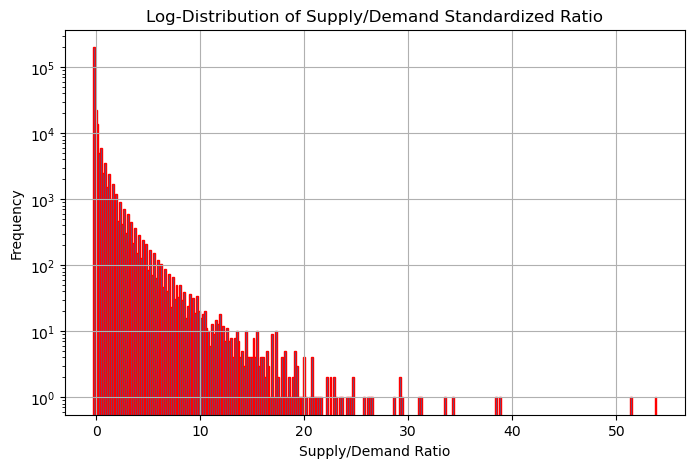

In [192]:
# Distribution of "ratio_zscore"
plt.figure(figsize=(8, 5))
df["ratio_zscore"].hist(bins=300, edgecolor="red")
plt.yscale("log")
plt.xlabel("Supply/Demand Ratio")
plt.ylabel("Frequency")
plt.title("Log-Distribution of Supply/Demand Standardized Ratio")
plt.show()

Our computed score gives 5 categories with balanced distribution 

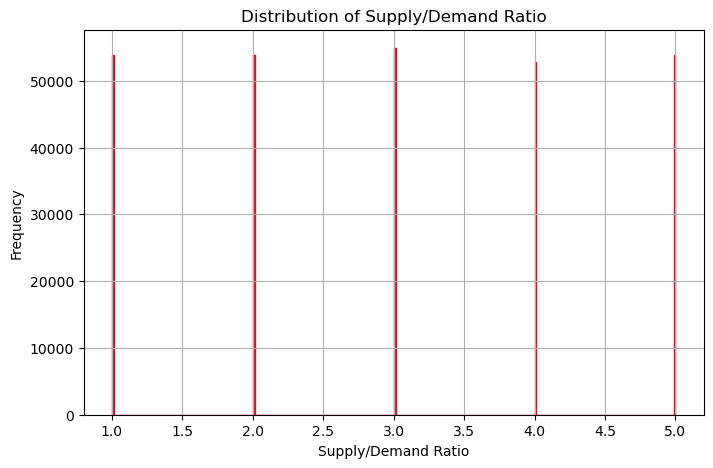

In [139]:
# Distribution of "job_offers_fap87"
plt.figure(figsize=(8, 5))
df["labour_tigthness_score"].hist(bins=300, edgecolor="red")
plt.xlabel("Supply/Demand Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Supply/Demand Ratio")
plt.show()

In [205]:
df.head(1)

,zone_emploi,fap87,month,labour_tigthness_score
0,Abbeville,A0Z,April,3


## 3- EXPORT FILE

In [206]:
# Keep columns of interest
columns_to_keep = ["zone_emploi", "fap87", "month", "labour_tigthness_score"]
df = df[columns_to_keep]

# EXPORT DATASET 
df.to_csv(output_path, index=False)